In [1]:
import os, sys
sys.path.append('/home/localadmin/Software/nifti_mrs_tools/src/mrs_tools/tools/')
sys.path.append('../common/nifti_mrs_from_raw/')
import importlib
from nifti_mrs_from_raw_pv3 import main as bruker2niimrs
import nifti_mrs_from_raw_pv3 as bruker2fsl
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
from pathlib import Path
import re
import fsl_mrs.utils.mrs_io as mrs_io
import fsl_mrs.core.nifti_mrs as ntools
from fsl_mrs.utils.preproc import nifti_mrs_proc as proc
import numpy as np

from datetime import datetime


from fsl_mrs.utils import preproc
from fsl_mrs.core import NIFTI_MRS
import nifti_mrs as ntools
from fsl_mrs.utils.misc import shift_FID

from nifti_mrs import create_nmrs


In [2]:
"""Tools for merging and splitting the dimensions of NIfTI-MRS

    Author: Will Clarke <william.clarke@ndcn.ox.ac.uk>
    Copyright (C) 2021 University of Oxford
"""
import re

import numpy as np

from nifti_mrs.nifti_mrs import NIFTI_MRS, NIFTIMRS_DimDoesntExist
from nifti_mrs import utils


def split(nmrs, dimension, index_or_indices):
    """Splits, or extracts indices from, a specified dimension of a
    NIFTI_MRS object. Output is two NIFTI_MRS objects. Header information preserved.

    :param nmrs: Input nifti_mrs object to split
    :type nmrs: fsl_mrs.core.nifti_mrs.NIFTI_MRS
    :param dimension: Dimension along which to split.
        Dimension tag or one of 4, 5, 6 (for 0-indexed 5th, 6th, and 7th)
    :type dimension: str or int
    :param index_or_indices: Single integer index to split after,
        or list of integer indices to insert into second array.
        E.g. '0' will place the first index into the first output
        and 1 -> N in the second.
        '[1, 5, 10]' will place 1, 5 and 10 into the second output
        and all other will remain in the first.
    :type index_or_indices: int or [int]
    :return: Two NIFTI_MRS object containing the split files
    :rtype: fsl_mrs.core.nifti_mrs.NIFTI_MRS
    """

    if isinstance(dimension, str):
        try:
            dim_index = nmrs.dim_position(dimension)
        except NIFTIMRS_DimDoesntExist:
            raise ValueError(f'{dimension} not found as dimension tag. This data contains {nmrs.dim_tags}.')
    elif isinstance(dimension, int):
        if dimension > (nmrs.ndim - 1) or dimension < 4:
            raise ValueError('Dimension must be one of 4, 5, or 6 (or DIM_TAG string).'
                             f' This data has {nmrs.ndim} dimensions,'
                             f' i.e. a maximum dimension value of {nmrs.ndim - 1}.')
        dim_index = dimension
    else:
        raise TypeError('Dimension must be an int (4, 5, or 6) or string (DIM_TAG string).')

    # Construct indexing
    if isinstance(index_or_indices, int):
        if index_or_indices < 0\
                or (index_or_indices + 1) >= nmrs.shape[dim_index]:
            raise ValueError('index_or_indices must be between 0 and N-1,'
                             f' where N is the size of the specified dimension ({nmrs.shape[dim_index]}).')
        index = np.arange(index_or_indices + 1, nmrs.shape[dim_index])

    elif isinstance(index_or_indices, list):
        if not np.logical_and(np.asarray(index_or_indices) >= 0,
                              np.asarray(index_or_indices) <= nmrs.shape[dim_index]).all():
            raise ValueError('index_or_indices must have elements between 0 and N,'
                             f' where N is the size of the specified dimension ({nmrs.shape[dim_index]}).')
        index = index_or_indices

    else:
        raise TypeError('index_or_indices must be single index or list of indices')

    # Split header down
    split_hdr_ext_1, split_hdr_ext_2 = _split_dim_header(nmrs.hdr_ext,
                                                         dim_index + 1,
                                                         nmrs.shape[dim_index],
                                                         index_or_indices)
    out_hdr_1 = utils.modify_hdr_ext(split_hdr_ext_1, nmrs.header)
    out_hdr_2 = utils.modify_hdr_ext(split_hdr_ext_2, nmrs.header)

    nmrs_1 = NIFTI_MRS(np.delete(nmrs[:], index, axis=dim_index), header=out_hdr_1)
    nmrs_2 = NIFTI_MRS(np.take(nmrs[:], index, axis=dim_index), header=out_hdr_2)

    return nmrs_1, nmrs_2


def _split_dim_header(hdr, dimension, dim_length, index):
    """Split dim_N_header keys in header extensions.

    :param hdr: Header extension to split
    :type hdr: dict
    :param dimension: Dimension (5, 6, or 7) to split along
    :type dimension: int
    :param dim_length: Length of dimension
    :type index: int
    :param index: Index to split after or indices to extract
    :type index: int or list of ints
    :return: Split header eextension dicts
    :rtype: dict
    """
    hdr1 = hdr.copy()
    hdr2 = hdr.copy()

    def split_list(in_list):
        if isinstance(index, int):
            out_1 = in_list[:(index + 1)]
            out_2 = in_list[(index + 1):]
        elif isinstance(index, list):
            out_1 = np.delete(np.asarray(in_list), index).tolist()
            out_2 = np.take(np.asarray(in_list), index).tolist()
        return out_1, out_2

    def split_user_or_std(hdr_val):
        if isinstance(hdr_val, dict)\
                and 'Value' in hdr_val:
            tmp_1, tmp_2 = split_list(hdr_val['Value'])
            out_1 = hdr_val.copy()
            out_2 = hdr_val.copy()
            out_1.update({'Value': tmp_1})
            out_2.update({'Value': tmp_2})
            return out_1, out_2
        else:
            return split_list(hdr_val)

    def split_single(hdr_val):
        hdr_type = utils.check_type(hdr_val)
        long_fmt = utils.dim_n_header_short_to_long(hdr_val, dim_length)
        long_fmt_1, long_fmt_2 = split_user_or_std(long_fmt)
        if hdr_type == 'long':
            return long_fmt_1, long_fmt_2
        else:
            return utils.dim_n_header_long_to_short(long_fmt_1), utils.dim_n_header_long_to_short(long_fmt_2)

    key_str = f'dim_{dimension}_header'
    key_str_tag = f'dim_{dimension}'
    key_str_info = f'dim_{dimension}_info'
    if key_str in hdr:
        new_h1 = {}
        new_h2 = {}
        for sub_key in hdr[key_str]:
            new_h1[sub_key], new_h2[sub_key] = split_single(hdr[key_str][sub_key])

        curr_tag = hdr[key_str_tag]
        if key_str_info in hdr:
            curr_info = hdr[key_str_info]
        else:
            curr_info = None
        hdr1.set_dim_info(dimension - 5, curr_tag, info=curr_info, hdr=new_h1)
        hdr2.set_dim_info(dimension - 5, curr_tag, info=curr_info, hdr=new_h2)

    return hdr1, hdr2


def merge(array_of_nmrs, dimension):
    """Concatenate NIfTI-MRS objects along specified higher dimension

    :param array_of_nmrs: Array of NIFTI-MRS objects to concatenate
    :type array_of_nmrs: tuple or list of fsl_mrs.core.nifti_mrs.NIFTI_MRS
    :param dimension: Dimension along which to concatenate.
        Dimension tag or one of 4, 5, 6 (for 0-indexed 5th, 6th, and 7th).
    :type dimension: int or str
    :return: Concatenated NIFTI-MRS object
    :rtype: fsl_mrs.core.nifti_mrs.NIFTI_MRS
    """
    if isinstance(dimension, str):
        try:
            dim_index = array_of_nmrs[0].dim_position(dimension)
        except NIFTIMRS_DimDoesntExist:
            raise ValueError(f'{dimension} not found as dimension tag. This data contains {array_of_nmrs[0].dim_tags}.')
    elif isinstance(dimension, int):
        if dimension > (array_of_nmrs[0].ndim - 1) or dimension < 4:
            raise ValueError('Dimension must be one of 4, 5, or 6 (or DIM_TAG string).'
                             f' This data has {array_of_nmrs[0].ndim} dimensions,'
                             f' i.e. a maximum dimension value of {array_of_nmrs[0].ndim - 1}.')
        dim_index = dimension
    else:
        raise TypeError('Dimension must be an int (4, 5, or 6) or string (DIM_TAG string).')

    # Check shapes and tags are compatible.
    # If they are and enter the data into a tuple for concatenation
    def check_shape(to_compare):
        for dim in range(to_compare.ndim):
            # Do not compare on selected dimension
            if dim == dim_index:
                continue
            if to_compare.shape[dim] != array_of_nmrs[0].shape[dim]:
                return False
        return True

    def check_tag(to_compare):
        for tdx in range(3):
            if array_of_nmrs[0].dim_tags[tdx] != to_compare.dim_tags[tdx]:
                return False
        return True

    to_concat = []
    for idx, nmrs in enumerate(array_of_nmrs):
        # Check shape
        if not check_shape(nmrs):
            raise utils.NIfTI_MRSIncompatible(
                'The shape of all concatenated objects must match.'
                f' The shape ({nmrs.shape}) of the {idx} object does'
                f' not match that of the first ({array_of_nmrs[0].shape}).')
        # Check dim tags for compatibility
        if not check_tag(nmrs):
            raise utils.NIfTI_MRSIncompatible(
                'The tags of all concatenated objects must match.'
                f' The tags ({nmrs.dim_tags}) of the {idx} object does'
                f' not match that of the first ({array_of_nmrs[0].dim_tags}).')

        if nmrs.shape[-1] == 1:
            # If a squeezed singleton on the end.
            to_concat.append(np.expand_dims(nmrs[:], -1))
        else:
            to_concat.append(nmrs[:])

        # Merge header extension
        if idx == 0:
            merged_hdr_ext = nmrs.hdr_ext
            merged_length = to_concat[-1].shape[dim_index]
        else:
            merged_hdr_ext = _merge_dim_header(merged_hdr_ext,
                                               nmrs.hdr_ext,
                                               dim_index + 1,
                                               merged_length,
                                               to_concat[-1].shape[dim_index])
            merged_length += to_concat[-1].shape[dim_index]

    out_hdr = utils.modify_hdr_ext(merged_hdr_ext, array_of_nmrs[0].header)

    return NIFTI_MRS(np.concatenate(to_concat, axis=dim_index), header=out_hdr)


def _merge_dim_header(hdr1, hdr2, dimension, dim_length1, dim_length2):
    """Merge dim_N_header keys in header extensions.
    Output header copies all other fields from hdr1

    :param hdr1: header extension from 1st file
    :type hdr1: dict
    :param hdr2: header extension from 2nd file
    :type hdr2: dict
    :param dimension: Dimension (5,6, or 7) to merge along
    :type dimension: int
    :param dim_length1: Dimension length of first file
    :type dimension: int
    :param dim_length2: Dimension length of second file
    :type dimension: int
    :return: Merged header extension dict
    :rtype: dict
    """
    out_hdr = hdr1.copy()

    def merge_list(list_1, list_2):
        return list_1 + list_2

    def merge_user_or_std(hdr_val1, hdr_val2):
        if isinstance(hdr_val1, dict)\
                and 'Value' in hdr_val1:
            tmp = merge_list(hdr_val1['Value'], hdr_val2['Value'])
            out = hdr_val1.copy()
            out.update({'Value': tmp})
            return out
        else:
            return merge_list(hdr_val1, hdr_val2)

    def merge_single(hdr_val1, hdr_val2):
        hdr_type = utils.check_type(hdr_val1)
        long_fmt_1 = utils.dim_n_header_short_to_long(hdr_val1, dim_length1)
        long_fmt_2 = utils.dim_n_header_short_to_long(hdr_val2, dim_length2)
        long_fmt = merge_user_or_std(long_fmt_1, long_fmt_2)
        if hdr_type == 'long':
            return long_fmt
        else:
            return utils.dim_n_header_long_to_short(long_fmt)

    key_str = f'dim_{dimension}_header'
    key_str_tag = f'dim_{dimension}'
    key_str_info = f'dim_{dimension}_info'

    def run_check():
        # Check all other dimension fields are consistent
        dim_n = re.compile(r'dim_[567].*')
        for key in hdr1:
            if dim_n.match(key) and key != key_str:
                if hdr1[key] != hdr2[key]:
                    raise utils.NIfTI_MRSIncompatible(
                        f'Both files must have matching dimension headers apart from the '
                        f'one being merged. {key} does not match.')

    if key_str in hdr1 and key_str in hdr2:
        run_check()
        # Check the subfields of the header to merge are consistent
        if not hdr1[key_str].keys() == hdr2[key_str].keys():
            raise utils.NIfTI_MRSIncompatible(
                f'Both NIfTI-MRS files must have matching dim {dimension} header fields.'
                f'The first header contains {hdr1[key_str].keys()}. '
                f'The second header contains {hdr2[key_str].keys()}.')
        new_h = {}
        for sub_key in hdr1[key_str]:
            new_h[sub_key] = merge_single(hdr1[key_str][sub_key], hdr2[key_str][sub_key])

        curr_tag = hdr1[key_str_tag]
        if key_str_info in hdr1:
            curr_info = hdr1[key_str_info]
        else:
            curr_info = None
        out_hdr.set_dim_info(dimension - 5, curr_tag, info=curr_info, hdr=new_h)
    elif key_str in hdr1 and key_str not in hdr2\
            or key_str not in hdr1 and key_str in hdr2:
        # Incompatible headers
        raise utils.NIfTI_MRSIncompatible(f'Both NIfTI-MRS files must have matching dim {dimension} header fields')
    elif key_str not in hdr1 and key_str not in hdr2:
        # Nothing to merge - still run check
        run_check()
    return out_hdr

def remove_dim(nmrs, remove_dim):
    """Removes a specficied dimension from a NIFTI_MRS object and returns a copy of the so modified NIFTI_MRS.
    Intuitive wrapper of NIFTI_MRS member funciton.

    :param nmrs: Input nifti_mrs object from which to remove dim
    :type nmrs: fsl_mrs.core.nifti_mrs.NIFTI_MRS
    :param remove_dim: dimension index (4, 5, 6) or tag to remove. Takes first index. 
    :type remove_dim: str or int
    :return: A NIFTI_MRS object with dimensionality reduced
    :rtype: fsl_mrs.core.nifti_mrs.NIFTI_MRS
    """
    return nmrs.copy(remove_dim)



In [3]:
def _read_header_file_info(file_path, keys_single, keys_array):
    """Read information from the method file

    :param file_path: path to the header file
    :type file_path: str or pathlib.Path
    :param keys_single: List of header keys that are a single value
    :type keys_single: list of str
    :param keys_array: List of header keys that have array values
    :type keys_array: list of str
    :return: Dict containing the information
    :rtype: dict
    """
    re_searches = [re.compile(fr'({x})\=(\d+)') for x in keys_single]
    re_searches2 = [re.compile(fr'({x})\=\((\s?\d+\s?)\)') for x in keys_array]

    with open(file_path) as fp:
        methodlines = fp.readlines()

    method_values = {}
    for line in methodlines:
        for re_ptrn in re_searches:
            match = re.search(re_ptrn, line)
            if match:
                method_values[match[1]] = int(match[2])

    # For array values that occur on the line after
    for idx, line in enumerate(methodlines):
        for re_ptrn in re_searches2:
            match = re.search(re_ptrn, line)
            if match:
                method_values[match[1]] = np.array(
                    methodlines[idx+1].split(' ')).astype('float')

    return method_values


In [4]:
# from https://git.fmrib.ox.ac.uk/fsl/fsl_mrs/-/blob/master/fsl_mrs/utils/preproc/nifti_mrs_proc.py

def remove_unlike(data, ppmlim=None, sdlimit=1.96, niter=2, figure=False, report=None, return_indices=False):
    '''Remove unlike dynamics operating on DIM_DYN

    :param NIFTI_MRS data: Data to truncate or pad
    :param figure: True to show figure.
    :param report: Provide output location as path to generate report

    :return: Data passing likeness criteria.
    :return: Data failing likness criteria
    '''
    if data.shape[:3] != (1, 1, 1):
        raise OnlySVS("remove_unlike only specified for SVS data")

    if data.ndim > 5:
        raise ValueError('remove_unlike only makes sense for a single dynamic dimension. Combined coils etc. first')
    elif data.ndim < 5:
        raise ValueError('remove_unlike only makes sense for data with a dynamic dimension')

    goodFIDs, badFIDs, gIndicies, bIndicies, metric = \
        preproc.identifyUnlikeFIDs(data[0, 0, 0, :, :].T,
                                   data.bandwidth,
                                   data.spectrometer_frequency[0],
                                   nucleus=data.nucleus[0],
                                   ppmlim=ppmlim,
                                   sdlimit=sdlimit,
                                   iterations=niter,
                                   shift=True)

    if figure or report:
        from fsl_mrs.utils.preproc.unlike import identifyUnlikeFIDs_report
        fig = identifyUnlikeFIDs_report(goodFIDs,
                                        badFIDs,
                                        gIndicies,
                                        bIndicies,
                                        metric,
                                        data.bandwidth,
                                        data.spectrometer_frequency[0],
                                        nucleus=data.nucleus[0],
                                        ppmlim=ppmlim,
                                        sdlimit=sdlimit,
                                        html=report)
        if figure:
            fig.show()

    # goodFIDs = np.asarray(goodFIDs).T
    # goodFIDs = goodFIDs.reshape([1, 1, 1] + list(goodFIDs.shape))

    if len(badFIDs) > 0:
        bad_out, good_out  = ntools.split(
            data,
            data.dim_tags[0],
            gIndicies)
    else:
        good_out = data.copy()

    good_out.add_hdr_field(
        f'{data.dim_tags[0]} Indices',
        gIndicies,
        doc=f"Data's original index values in the {data.dim_tags[0]} dimension")

    if len(badFIDs) > 0:
        bad_out.add_hdr_field(
            f'{data.dim_tags[0]} Indices',
            bIndicies,
            doc=f"Data's original index values in the {data.dim_tags[0]} dimension")
    else:
        bad_out = None

    # Update processing prov
    processing_info = f'{__name__}.remove_unlike, '
    if ppmlim is None:
        processing_info += 'ppmlim=None, '
    else:
        processing_info += f'ppmlim={ppmlim}, '
    processing_info += f'sdlimit={sdlimit}, '
    processing_info += f'niter={niter}.'

    update_processing_prov(good_out, 'Outlier removal', processing_info)

    if return_indices:
        return gIndicies, bIndicies
    return good_out, bad_out


# MRS raw data preprocessing

In [5]:
path_to_data='/media/localadmin/DATA/data/20250424/'
water_reference_seqeunce_number = '41'

The raw data has entries resulting from being complex (dim 2), 4 coil loops, 4096 FID points, and in this case 8 averages.

## Process reference data

In [6]:
water_reference_seqeunce_number = '41'
bruker2niimrs(f'{path_to_data}/{water_reference_seqeunce_number}/rawdata.job0', f'{path_to_data}/{water_reference_seqeunce_number}/rawdata_nifti')
ref_data = mrs_io.read_FID(f'{path_to_data}/{water_reference_seqeunce_number}/rawdata_nifti.nii.gz')
print(f'Loaded with shape { ref_data.shape} and dimensions { ref_data.dim_tags}.')

Loaded with shape (1, 1, 1, 4096, 4, 8, 1) and dimensions ['DIM_COIL', 'DIM_DYN', 'DIM_USER_0'].


In [7]:
ref_data

File rawdata_nifti.nii.gz (/media/localadmin/DATA/data/20250424/41)
NIfTI-MRS version 0.9
Data shape (1, 1, 1, 4096, 4, 8, 1)
Dimension tags: ['DIM_COIL', 'DIM_DYN', 'DIM_USER_0']
Spectrometer Frequency: 400.263989952738 MHz
Dwelltime (Spectral bandwidth): 2.000E-04 s (5000 Hz)
Nucleus: 1H
Field Strength: 9.40 T

In [9]:
ntools.tools.split_merge.remove_dim(ref_data,'DIM_USER_0')

NIfTI-MRS version 0.9
Data shape (1, 1, 1, 4096, 4, 8)
Dimension tags: ['DIM_COIL', 'DIM_DYN', None]
Spectrometer Frequency: 400.263989952738 MHz
Dwelltime (Spectral bandwidth): 2.000E-04 s (5000 Hz)
Nucleus: 1H
Field Strength: 9.40 T

In [39]:
ref_data = ntools.reshape(ref_data,(4,1,8))
for i,dim in enumerate(ref_data.dim_tags):
    print(dim)
    if ref_data.shape[4+i]==1:
        ref_data_crop = ref_data.copy(remove_dim=4+i)
ref_data=ref_data_crop

DIM_COIL
DIM_DYN
DIM_USER_0


In [40]:
even_reps = [2*n for n in range(ref_data.shape[5]//2)]
ref_data_even, ref_data_odd = ntools.split(ref_data,5,even_reps)

In [41]:
avg_ref_data_even = proc.average(ref_data_even, 'DIM_USER_0',report='./report_ref_av_even.html')
avg_ref_data_odd = proc.average(ref_data_odd, 'DIM_USER_0',report='./report_ref_av_odd.html')

## Process metabolite data

In [321]:
min_seq_number = 42
max_seq_number = 62
data = []
for seq_number in range(min_seq_number,max_seq_number+1):
    bruker2niimrs(f'{path_to_data}/{seq_number}/rawdata.job0', f'{path_to_data}/{seq_number}/rawdata_nifti')
    data.append(mrs_io.read_FID(f'{path_to_data}/{seq_number}/rawdata_nifti.nii.gz'))
    print(f'Loaded with shape { data[-1].shape} and dimensions { data[-1].dim_tags}.')

Loaded with shape (1, 1, 1, 4096, 4, 1, 128) and dimensions ['DIM_COIL', 'DIM_DYN', 'DIM_USER_0'].
Loaded with shape (1, 1, 1, 4096, 4, 1, 128) and dimensions ['DIM_COIL', 'DIM_DYN', 'DIM_USER_0'].
Loaded with shape (1, 1, 1, 4096, 4, 1, 128) and dimensions ['DIM_COIL', 'DIM_DYN', 'DIM_USER_0'].
Loaded with shape (1, 1, 1, 4096, 4, 1, 128) and dimensions ['DIM_COIL', 'DIM_DYN', 'DIM_USER_0'].
Loaded with shape (1, 1, 1, 4096, 4, 1, 128) and dimensions ['DIM_COIL', 'DIM_DYN', 'DIM_USER_0'].
Loaded with shape (1, 1, 1, 4096, 4, 1, 128) and dimensions ['DIM_COIL', 'DIM_DYN', 'DIM_USER_0'].
Loaded with shape (1, 1, 1, 4096, 4, 1, 128) and dimensions ['DIM_COIL', 'DIM_DYN', 'DIM_USER_0'].
Loaded with shape (1, 1, 1, 4096, 4, 1, 128) and dimensions ['DIM_COIL', 'DIM_DYN', 'DIM_USER_0'].
Loaded with shape (1, 1, 1, 4096, 4, 1, 128) and dimensions ['DIM_COIL', 'DIM_DYN', 'DIM_USER_0'].
Loaded with shape (1, 1, 1, 4096, 4, 1, 128) and dimensions ['DIM_COIL', 'DIM_DYN', 'DIM_USER_0'].
Loaded wit

Average over trivial dimensions to adapt data to FSL MRS format

In [322]:
for j,this_data in enumerate(data):
    for i,dim in enumerate(this_data.dim_tags):
        if this_data.shape[4+i]==1:
            data[j] = this_data.copy(remove_dim=dim)
        

In [323]:
data_even = []
data_odd = []
for this_data in data:
    even_reps = [2*n for n in range(this_data.shape[5]//2)]
    this_data_even, this_data_odd = ntools.split(this_data,5,even_reps)
    data_even.append(this_data_even)
    data_odd.append(this_data_odd)
    

Think about replacing coil combination with Jessie's script

In [324]:
data_even_cc = []
data_odd_cc = []

for this_data in data_even:
    data_even_cc.append(proc.coilcombine(this_data,reference=avg_ref_data_even,figure=False))
    
for this_data in data_odd:
    data_odd_cc.append(proc.coilcombine(this_data,reference=avg_ref_data_odd,figure=False))

You may not have enough samples to accurately estimate the noise covariance, 10^5 samples recommended.
You may not have enough samples to accurately estimate the noise covariance, 10^5 samples recommended.
You may not have enough samples to accurately estimate the noise covariance, 10^5 samples recommended.
You may not have enough samples to accurately estimate the noise covariance, 10^5 samples recommended.
You may not have enough samples to accurately estimate the noise covariance, 10^5 samples recommended.
You may not have enough samples to accurately estimate the noise covariance, 10^5 samples recommended.
You may not have enough samples to accurately estimate the noise covariance, 10^5 samples recommended.
You may not have enough samples to accurately estimate the noise covariance, 10^5 samples recommended.
You may not have enough samples to accurately estimate the noise covariance, 10^5 samples recommended.
You may not have enough samples to accurately estimate the noise covarian

In [325]:
data_even_cc_shift = []
data_odd_cc_shift = []

for this_data in data_even_cc:
    data_even_cc_shift.append(proc.apply_fixed_phase(this_data,245))
    
for this_data in data_odd_cc:
    data_odd_cc_shift.append(proc.apply_fixed_phase(this_data,245))   

Averaging DIM_USER_0


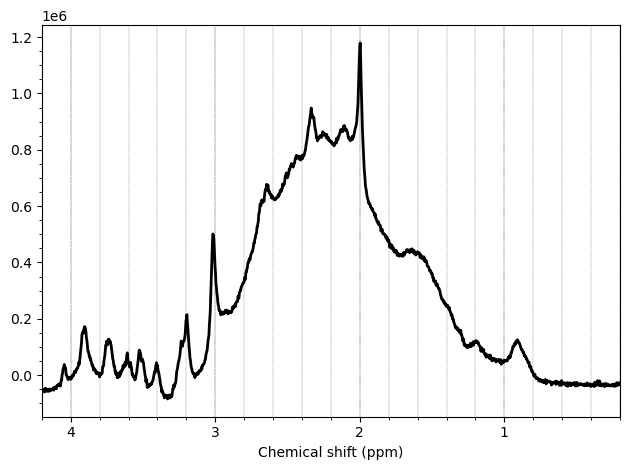

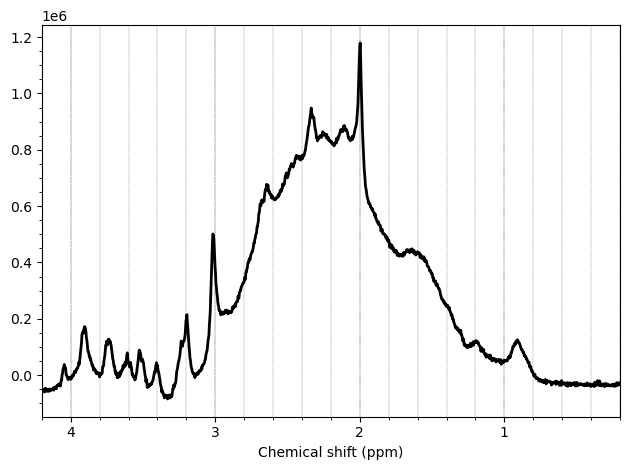

In [326]:
data_odd_cc_shift[0].plot(plot_avg=True)

In [327]:
data_even_cc_shift_align = []
data_odd_cc_shift_align = []

for this_data in data_even_cc_shift:
    data_even_cc_shift_align.append(proc.align(this_data, 'DIM_USER_0', ppmlim=(0.2,4.2), figure=False))

for this_data in data_odd_cc_shift:
    data_odd_cc_shift_align.append(proc.align(this_data, 'DIM_USER_0', ppmlim=(0.2,4.2), figure=False))


In [340]:
data_even_cc_shift_align[0]

NIfTI-MRS version 0.9
Data shape (1, 1, 1, 4096, 64)
Dimension tags: ['DIM_USER_0', None, None]
Spectrometer Frequency: 400.263989952738 MHz
Dwelltime (Spectral bandwidth): 2.000E-04 s (5000 Hz)
Nucleus: 1H
Field Strength: 9.40 T

In [357]:
a

NIfTI-MRS version 0.9
Data shape (1, 1, 1, 4096, 1)
Dimension tags: ['DIM_USER_0', None, None]
Spectrometer Frequency: 400.263989952738 MHz
Dwelltime (Spectral bandwidth): 2.000E-04 s (5000 Hz)
Nucleus: 1H
Field Strength: 9.40 T

In [358]:
subset,a = ntools.split(data_even_cc_shift_align[0],'DIM_USER_0',[0])
subset,b = ntools.split(data_odd_cc_shift_align[0],'DIM_USER_0',[0])

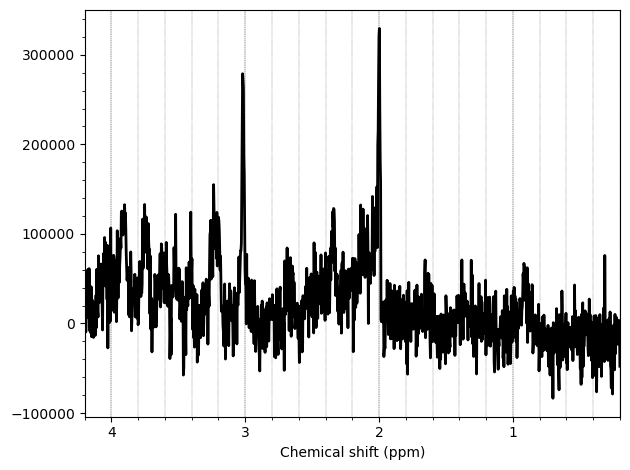

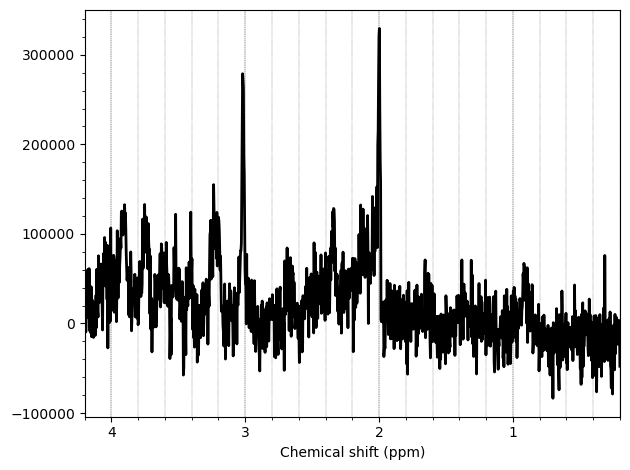

In [359]:
proc.add(a,b).plot()
#data_odd_cc_shift_align[0].plot()

In [396]:
from fsl_mrs import __version__


def update_processing_prov(nmrs_obj: NIFTI_MRS, method, details):
    """Insert appropriate processing provenance information into the
    NIfTI-MRS header extension.

    :param nmrs_obj: NIFTI-MRS object which has been modified
    :type nmrs_obj: fsl_mrs.core.NIFTI_MRS
    :param method: [description]
    :type method: str
    :param details: [description]
    :type details: str
    """
    # 1. Check for ProcessingApplied key and create if not present
    if 'ProcessingApplied' in nmrs_obj.hdr_ext:
        current_processing = nmrs_obj.hdr_ext['ProcessingApplied']
    else:
        current_processing = []

    # 2. Form object to append.
    prov_dict = {
        'Time': datetime.now().isoformat(sep='T', timespec='milliseconds'),
        'Program': 'FSL-MRS',
        'Version': __version__,
        'Method': method,
        'Details': details}

    # 3. Append
    current_processing.append(prov_dict)
    nmrs_obj.add_hdr_field('ProcessingApplied', current_processing)


In [407]:
ppmlim = (0.2,4.3)
data_even_cc_shift_align_unlike_good_ind = []
data_odd_cc_shift_align_unlike_good_ind = []

data_even_cc_shift_align_unlike_bad_ind = []
data_odd_cc_shift_align_unlike_bad_ind = []


for this_data in data_even_cc_shift_align:
    this_unlike = remove_unlike(this_data, ppmlim=ppmlim,return_indices=True)
    data_even_cc_shift_align_unlike_good_ind.append(this_unlike[0])
    data_even_cc_shift_align_unlike_bad_ind.append(this_unlike[1])
for this_data in data_odd_cc_shift_align:
    this_unlike = remove_unlike(this_data, ppmlim=ppmlim,return_indices=True)
    data_odd_cc_shift_align_unlike_good_ind.append(this_unlike[0])
    data_odd_cc_shift_align_unlike_bad_ind.append(this_unlike[1])


Combine on and off SPECIAL repetitions

In [474]:
data_combined_cc_shift_align_unlike = []
for j,this_data in enumerate(data_even_cc_shift_align):
    these_good_data = []
    for i in range(this_data.shape[-1]):
        # only consider data where both even and odd version is not an outlier
        if (i in data_even_cc_shift_align_unlike_good_ind[j]) and (i in data_odd_cc_shift_align_unlike_good_ind[j]) and (i!=63):
            # take out data to add
            scrap, this_even_rep = ntools.split(data_even_cc_shift_align[j],4,[i])
            scrap, this_odd_rep = ntools.split(data_odd_cc_shift_align[j],4,[i])
            # add data and append
            these_good_data.append(proc.add(this_even_rep,this_odd_rep))
    # stack along repetition dimension
    data_combined_cc_shift_align_unlike.append(ntools.merge(these_good_data,'DIM_USER_0'))

In [475]:
data_combined_cc_shift_align_unlike_av = []

for this_data in data_combined_cc_shift_align_unlike:
    data_combined_cc_shift_align_unlike_av.append(proc.average(this_data, 'DIM_USER_0'))
        

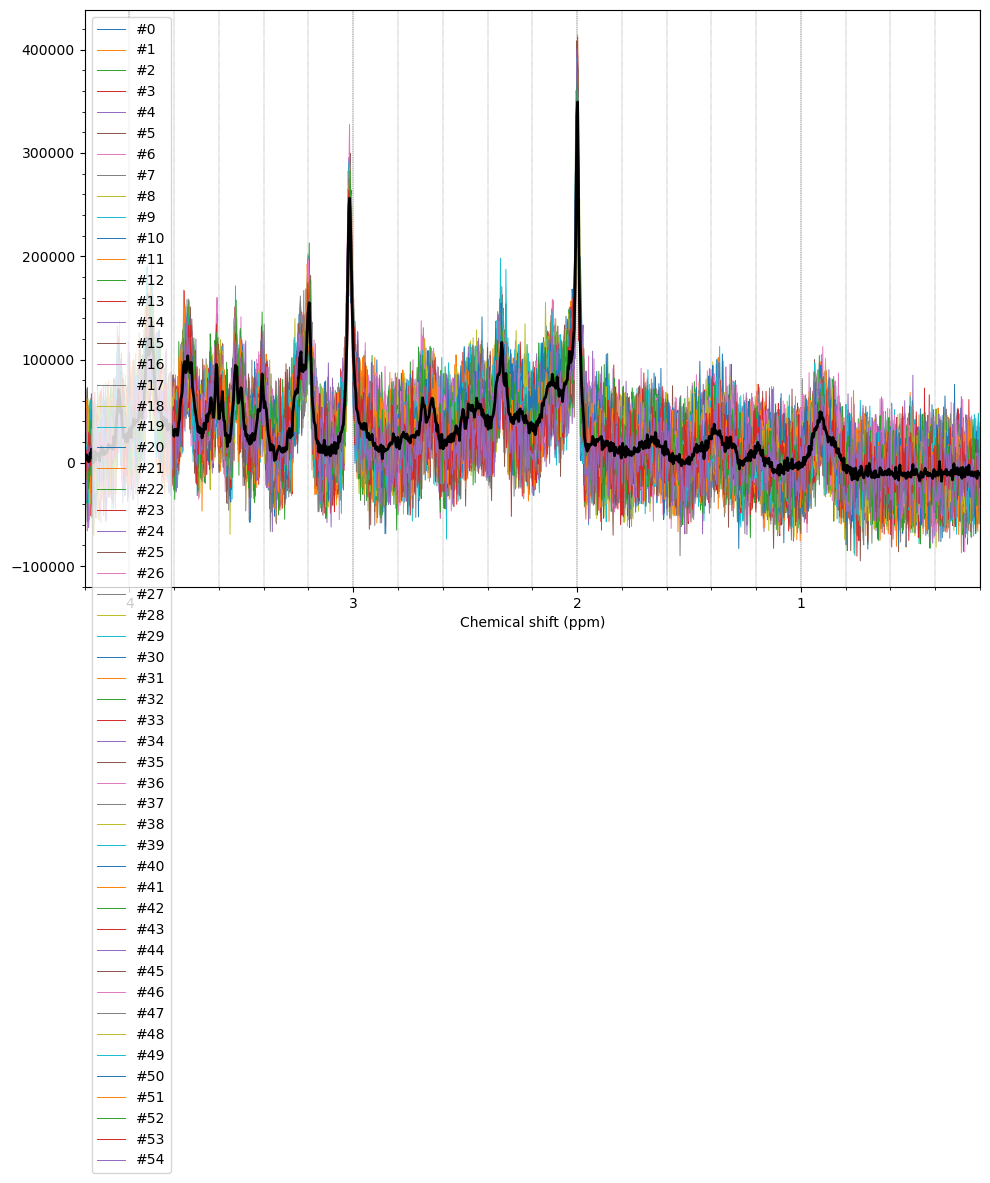

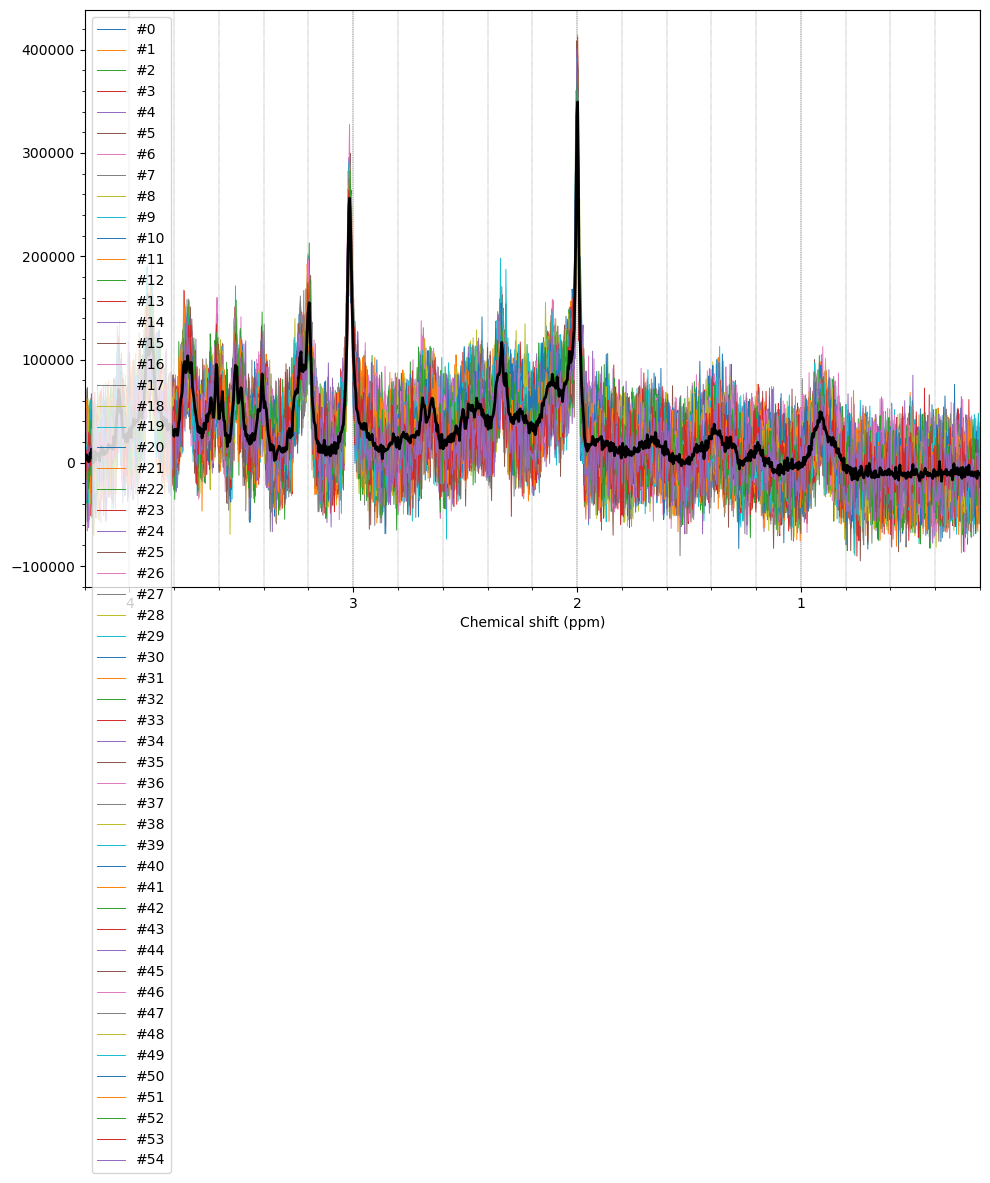

In [478]:
data_combined_cc_shift_align_unlike[0].plot(display_dim='DIM_USER_0')
data_combined_cc_shift_align_unlike_av[0].plot()

Eddy current correction: First coil-combine water reference, then ecc

In [481]:
avg_ref_data_even_cc = proc.coilcombine(avg_ref_data_even,reference=avg_ref_data_even)
avg_ref_data_odd_cc = proc.coilcombine(avg_ref_data_odd,reference=avg_ref_data_odd)

You may not have enough samples to accurately estimate the noise covariance, 10^5 samples recommended.
You may not have enough samples to accurately estimate the noise covariance, 10^5 samples recommended.


In [482]:
avg_ref_data_even_cc_shift = proc.apply_fixed_phase(avg_ref_data_even_cc,245)
avg_ref_data_odd_cc_shift = proc.apply_fixed_phase(avg_ref_data_odd_cc,245)

In [483]:
avg_ref_data_even_cc_shift

NIfTI-MRS version 0.9
Data shape (1, 1, 1, 4096)
Dimension tags: [None, None, None]
Spectrometer Frequency: 400.263989952738 MHz
Dwelltime (Spectral bandwidth): 2.000E-04 s (5000 Hz)
Nucleus: 1H
Field Strength: 9.40 T

In [484]:
avg_ref_data_combined_cc_shift = proc.add(avg_ref_data_even_cc_shift,avg_ref_data_odd_cc_shift)

In [487]:
data_combined_cc_shift_align_unlike_av_ecc = []

for this_data in data_combined_cc_shift_align_unlike_av:
    data_combined_cc_shift_align_unlike_av_ecc.append(proc.ecc(this_data, avg_ref_data_combined_cc_shift))


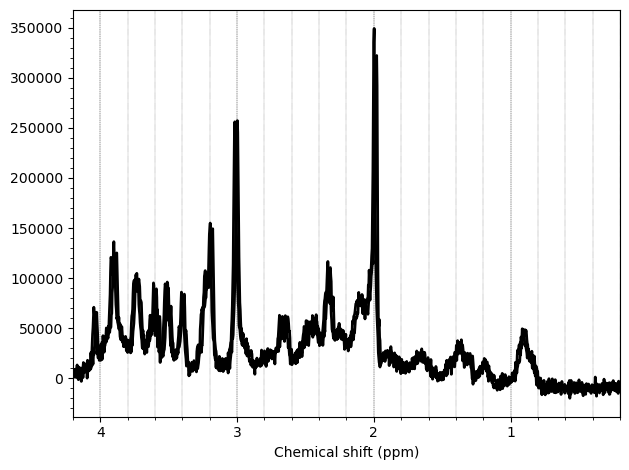

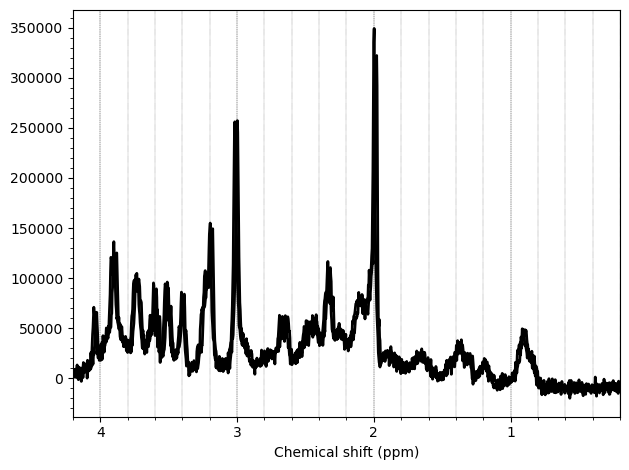

In [489]:
data_combined_cc_shift_align_unlike_av[0].plot()
data_combined_cc_shift_align_unlike_av_ecc[0].plot()

Truncation etc needed? Double check Jessies script.

In [492]:
limits = [-0.15,0.15]
limunits = 'ppm'

data_combined_cc_shift_align_unlike_av_ecc_watersupp = [proc.remove_peaks(this_data, limits, limit_units=limunits) 
                                                        for this_data in data_combined_cc_shift_align_unlike_av_ecc]

In [493]:
data_combined_cc_shift_align_unlike_av_ecc_watersupp_refshift = [proc.shift_to_reference(this_data, 3.027, (2.9, 3.1)) 
                                                                 for this_data in data_combined_cc_shift_align_unlike_av_ecc_watersupp ]

In [495]:
data_combined_cc_shift_align_unlike_av_ecc_watersupp_refshift_phased = [proc.phase_correct(this_data, (2.9, 3.1))
                                                                        for this_data in data_combined_cc_shift_align_unlike_av_ecc_watersupp_refshift]
avg_ref_data_combined_cc_shift_phased = proc.phase_correct(avg_ref_data_combined_cc_shift, (4.55, 4.7), hlsvd=False)

In [504]:
range(min_seq_number,max_seq_number+1)
for i,this_data in enumerate(data_combined_cc_shift_align_unlike_av_ecc_watersupp_refshift_phased):
    this_data.save(f'{path_to_data}/{min_seq_number+i}/rawdata_nifti_preproc.nii.gz')

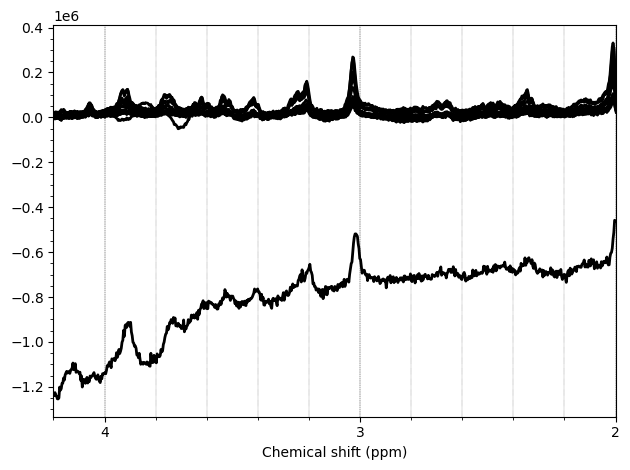

In [502]:
[data_combined_cc_shift_align_unlike_av_ecc_watersupp_refshift_phased[i].plot() for i in range(10)]
avg_ref_data_combined_cc_shift_phased.plot(ppmlim=(2,4.2));

In [ ]:
avg_ref_data_combined_cc_shift_phased.save()

# LATER: USE EPFL COIL COMBINE instead of water reference peak. 

## Get SPECIAL rephasing into nifti read

In [124]:
BRUKERparamnames=["PVM_ArrayPhase", 
                  "PVM_EncChanScaling"];

In [125]:
hdr = _read_header_file_info(f'{path_to_data}/{water_reference_seqeunce_number}/method',[],BRUKERparamnames)

In [126]:
rxarrayphases = hdr['PVM_ArrayPhase']
scalingloops = hdr['PVM_EncChanScaling']

In [27]:
nbtsfid = 4096
nloops = 4

raw_data_coil_rep = []
for coil in range(nloops):
    raw_data_coil_rep.append([])
    for avrep in range(8):
        this_raw = raw_data[(avrep*nbtsfid*2*nloops + coil * nbtsfid*2):(avrep*nbtsfid*2*nloops + coil * nbtsfid*2 + 2*nbtsfid)]
        this_raw_cmplx = this_raw[::2] + 1j*this_raw[1::2]
        raw_data_coil_rep[coil].append(this_raw_cmplx)
raw_data_coil_rep = np.array(raw_data_coil_rep)

In [ ]:
fid_comb_re=zeros(study.nav*study.nrep,nbptsfid);
fid_comb_im=zeros(study.nav*study.nrep,nbptsfid);

fid_reorganized_rephased_re=zeros(nloops,study.nav*study.nrep,nbptsfid);
fid_reorganized_rephased_im=zeros(nloops,study.nav*study.nrep,nbptsfid);

for coil=1:nloops
    fid_comb_re=fid_comb_re + ...
                    (squeeze(real(fid_reorganized(coil,:,:))).*cos(rxarrayphases(coil)/180*pi) ... 
                    -squeeze(imag(fid_reorganized(coil,:,:))).*sin(rxarrayphases(coil)/180*pi)).*scalingloops(coil);

    fid_reorganized_rephased_re(coil,:,:)=(squeeze(real(fid_reorganized(coil,:,:))).*cos(rxarrayphases(coil)/180*pi) ... 
                    -squeeze(imag(fid_reorganized(coil,:,:))).*sin(rxarrayphases(coil)/180*pi)).*scalingloops(coil);

    fid_comb_im= fid_comb_im+ ...
                    (squeeze(real(fid_reorganized(coil,:,:))).*sin(rxarrayphases(coil)/180*pi) ... 
                    +squeeze(imag(fid_reorganized(coil,:,:))).*cos(rxarrayphases(coil)/180*pi)).*scalingloops(coil);

    fid_reorganized_rephased_im(coil,:,:)=(squeeze(real(fid_reorganized(coil,:,:))).*sin(rxarrayphases(coil)/180*pi) ... 
                    +squeeze(imag(fid_reorganized(coil,:,:))).*cos(rxarrayphases(coil)/180*pi)).*scalingloops(coil);
end 


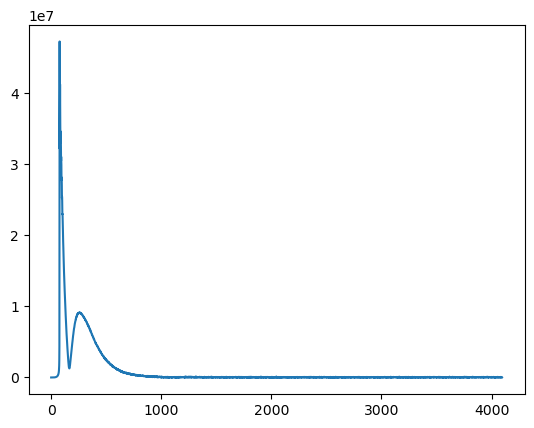

In [39]:
plt.plot(np.absolute(raw_data_coil_rep[0,3,:]))

In [151]:
matdata = loadmat('/data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/Bruker_2025-04-24_41_Toi_check_fidrefscan.mat')

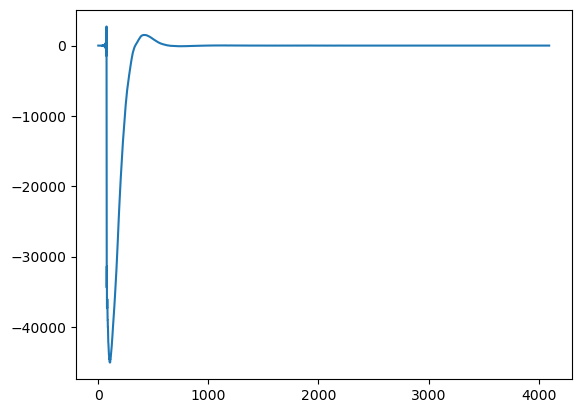

In [152]:
plt.plot(matdata['study'][0]['data'][0]['real'][0][0][0,0])

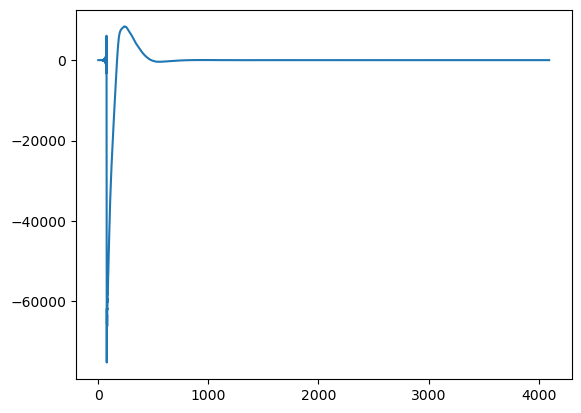

In [153]:
plt.plot(matdata['study'][0]['data'][0]['imag'][0][0][0,0])

In [161]:
matdata['study'][0]['data'][0]['real'][0][0].shape

(1, 1, 4096)

In [162]:
cmplx = matdata['study'][0]['data'][0]['imag'][0][0][:,0]+matdata['study'][0]['data'][0]['real'][0][0][:,0]

In [163]:
absolute = np.absolute(cmplx)

In [243]:
raw_data_cmplx = (raw_data[0::2] + 1j * raw_data[1::2])/2

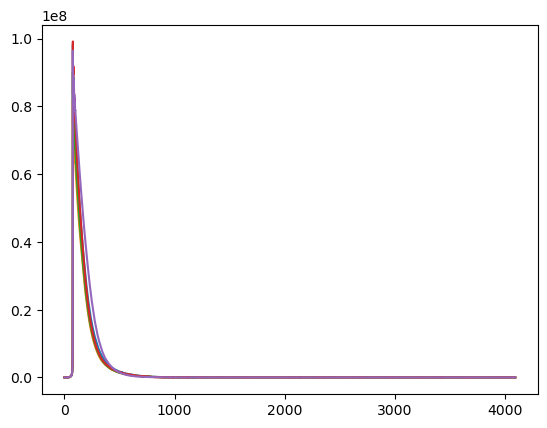

In [250]:
for i in range(8,12):
    plt.plot(np.absolute(raw_data_cmplx[i*4096:(i+1)*4096]))

plt.plot(np.sqrt(matdata['study'][0]['data'][0]['imag'][0][0][0,0]**2+matdata['study'][0]['data'][0]['real'][0][0][0,0]**2)*3000)

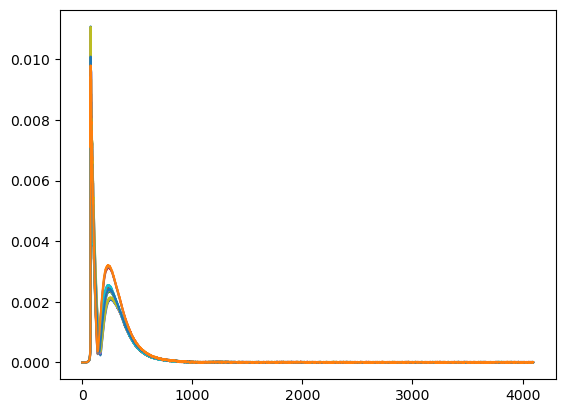

In [208]:
for i in range(4,8):
    plt.plot(np.absolute(raw_data_cmplx[i*4096:(i+1)*4096]))
for i in range(12,16):
    plt.plot(np.absolute(raw_data_cmplx[i*4096:(i+1)*4096]))
for i in range(20,24):
    plt.plot(np.absolute(raw_data_cmplx[i*4096:(i+1)*4096]))


# Old and not working

In [16]:
data_nii_path = f'{path_to_data}/{seqeunce_number}/rawdata_nifti.nii.gz'
water_nii_path = f'{path_to_data}/{water_reference_seqeunce_number}/rawdata_nifti.nii.gz'

In [30]:
data_nii_path

'/data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/51/rawdata_nifti.nii.gz'

In [29]:
!mrs_tools vis $water_nii_path

Performing coil combination
/software/fsl/6.0.7.11/debian-bullseye-amd64/lib/python3.11/site-packages/fsl_mrs/utils/preproc/combine.py:48: UserWarning:

You may not have enough samples to accurately estimate the noise covariance, 10^5 samples recommended.

Averaging DIM_DYN
Figure(640x480)


In [18]:
!fsl_mrs_preproc --output output/ --data $data_nii_path --reference $water_nii_path --report

/software/fsl/6.0.7.11/debian-bullseye-amd64/lib/python3.11/site-packages/fsl_mrs/utils/preproc/combine.py:48: UserWarning:

You may not have enough samples to accurately estimate the noise covariance, 10^5 samples recommended.

Traceback (most recent call last):
  File "/software/fsl/6.0.7.11/debian-bookworm-amd64/bin/fsl_mrs_preproc", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/software/fsl/6.0.7.11/debian-bullseye-amd64/lib/python3.11/site-packages/fsl_mrs/scripts/fsl_mrs_preproc.py", line 240, in main
    supp_data = nifti_mrs_proc.coilcombine(
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/software/fsl/6.0.7.11/debian-bullseye-amd64/lib/python3.11/site-packages/fsl_mrs/utils/preproc/nifti_mrs_proc.py", line 134, in coilcombine
    _, ref_weights[idx_no_t], _ = preproc.combine_FIDs(
       ~~~~~~~~~~~^^^^^^^^^^
ValueError: could not broadcast input array from shape (4,) into shape (4,1)


In [15]:
!echo --output output/ --data $data_nii_path

--output output/ --data /data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/51/rawdata_nifti.nii.gz


In [44]:
import os, subprocess
import brukerapi
from brukerapi.folders import Study
from brukerapi.dataset import Dataset
from matplotlib import pyplot as plt
import spec2nii as s2n
from spec2nii import bruker as b2n
from spec2nii.spec2nii import main, spec2nii

In [24]:
brukerapi

<module 'brukerapi' from '/data/u_mbrammerloh_diss/tools/anaconda3/lib/python3.12/site-packages/brukerapi/__init__.py'>

In [4]:
spec2nii_command = "./spec2nii bruker -m FID "
subprocess.call(spec2nii_command)

FileNotFoundError: [Errno 2] No such file or directory: './spec2nii bruker -m FID '

In [112]:
study = Dataset('/data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/47/fid')

ZeroDivisionError: float division by zero

In [111]:
study = Study('/data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/',)

NotStudyFolder: Not a Bruker study folder.

In [105]:
study.dim_type

['spectroscopic', '<FG_CYCLE>']

[[<matplotlib.lines.Line2D at 0x7f0ebd74ae10>]]

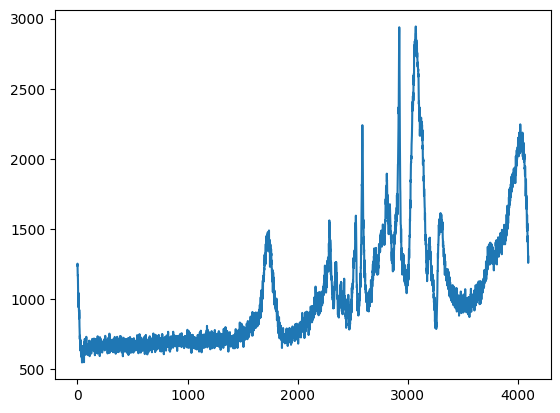

In [104]:
[plt.plot(study.data[:].mean(axis=1))]

In [7]:
data_folder='/data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424'
for sequencedir in range(41,63):
    spec2nii_command = "spec2nii bruker -m 2DSEQ " + os.path.join(data_folder,str(sequencedir), 'pdata','1','2dseq')
    print(spec2nii_command)
    subprocess.call(spec2nii_command)
    break


spec2nii bruker -m 2DSEQ /data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/41/pdata/1/2dseq


FileNotFoundError: [Errno 2] No such file or directory: 'spec2nii bruker -m 2DSEQ /data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/41/pdata/1/2dseq'

In [107]:
!spec2nii bruker /data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/41/fid

Traceback (most recent call last):
  File "/data/u_mbrammerloh_diss/tools/anaconda3/bin/spec2nii", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/data/u_mbrammerloh_diss/tools/anaconda3/lib/python3.12/site-packages/spec2nii/spec2nii.py", line 701, in main
    spec2nii(*args)
  File "/data/u_mbrammerloh_diss/tools/anaconda3/lib/python3.12/site-packages/spec2nii/spec2nii.py", line 297, in __init__
    args.func(args)
  File "/data/u_mbrammerloh_diss/tools/anaconda3/lib/python3.12/site-packages/spec2nii/spec2nii.py", line 670, in bruker
    self.imageOut, self.fileoutNames = read_bruker(args)
                                       ^^^^^^^^^^^^^^^^^
  File "/data/u_mbrammerloh_diss/tools/anaconda3/lib/python3.12/site-packages/spec2nii/bruker.py", line 44, in read_bruker
    for data, orientation, dwelltime, meta, name in yield_bruker(args):
  File "/data/u_mbrammerloh_diss/tools/anaconda3/lib/python3.12/site-packages/spec2nii/bruker.py", line 79, in yield_bruker
    

In [ ]:
read_bruker()


In [13]:
spec2nii()

TypeError: 'module' object is not callable

In [60]:
""" spec2nii - tool for conversion of various MRS data formats to NIFTI format.

This module contains the main class to be called as a script (through the main function).

Author: William Clarke <william.clarke@ndcn.ox.ac.uk>
Copyright (C) 2020 University of Oxford
"""

import argparse
import sys
import os.path as op
from pathlib import Path
import json
from nibabel.nifti2 import Nifti2Image
from spec2nii import __version__ as spec2nii_ver
from numpy import isclose
# There are case specific imports below


class Spec2niiError(Exception):
    pass


class spec2nii:
    def __init__(self):
        cite_str = "Clarke WT, Bell TK, Emir UE, Mikkelsen M, Oeltzschner G, Shamaei A, Soher BJ, Wilson M. "\
                   "NIfTI-MRS: A standard data format for magnetic resonance spectroscopy. "\
                   "Magn Reson Med. 2022. doi: 10.1002/mrm.29418."
        parser = argparse.ArgumentParser(
            description='Convert raw spectroscopy data to NIfTI format.',
            epilog=f"If you use spec2nii please cite: {cite_str}")
        parser.add_argument('-v', '--version', action='version', version=spec2nii_ver)

        subparsers = parser.add_subparsers(title='spec2nii subcommands')

        def add_common_parameters(subparser):
            # Add options that are common to all subcommands
            subparser.add_argument('-j', '--json', help='Create json sidecar.', action='store_true')
            subparser.add_argument("-f", "--fileout", type=str,
                                   help="Output file base name (default = input file name)")
            subparser.add_argument("-o", "--outdir", type=Path,
                                   help="Output location (default = .)", default='.')
            subparser.add_argument('--nifti1', action='store_true')
            subparser.add_argument("--override_nucleus", type=str, nargs='+',
                                   help="Override ResonantNucleus field with input(s). E.g. '2H'.")
            subparser.add_argument("--override_frequency", type=float, nargs='+',
                                   help="Override SpectrometerFrequency field with input(s). Input in MHz.")
            subparser.add_argument("--override_dwelltime", type=float,
                                   help="Override dwell time field with input. Input in seconds.")
            subparser.add_argument(
                '--anon',
                action='store_true',
                help="Create file without sensitive metadata. For greater control use spec2nii anon.")
            subparser.add_argument('--verbose', action='store_true')

            return subparser


        # Bruker format
        parser_bruker = subparsers.add_parser('bruker', help='Convert from Bruker data format.')
        parser_bruker.add_argument('file', help='2dseq file to convert', type=str)
        parser_bruker.add_argument('-q', '--query', action='append', default=[])
        parser_bruker.add_argument('-m', '--mode', type=str, default='2DSEQ', choices=['2DSEQ', 'FID'])
        parser_bruker.add_argument('-d', '--dump_headers',
                                   help='Dump bruker header files into json header extension',
                                   action='store_true')
        parser_bruker = add_common_parameters(parser_bruker)
        parser_bruker.set_defaults(func=self.bruker)


        if len(sys.argv) == 1:
            parser.print_usage(sys.stderr)
            sys.exit(1)

        args = parser.parse_args()

        self.fileoutNames = []
        self.imageOut = []
        self.orientationInfoOut = []
        self.dwellTimes = []
        self.metaData = []

        self.outputDir = args.outdir

        args.func(args)

        return args
        if self.imageOut:
            self.implement_overrides(args)

            self.insert_spectralwidth()

            if args.anon:
                from spec2nii.anonymise import anon_nifti_mrs
                for idx, nifti_mrs_img in enumerate(self.imageOut):
                    self.imageOut[idx] = anon_nifti_mrs(nifti_mrs_img, verbose=args.verbose)

            self.validate_output()
            self.write_output(args.json, args.nifti1)
            self.validate_write(args.verbose)
            if args.verbose:
                print(f'Please cite {cite_str}.')
        elif hasattr(args, 'view') and not args.view:
            print('No files to write.')

    def implement_overrides(self, args):
        """Implement any command line overrides for essential parameters."""
        for nifti_mrs_img in self.imageOut:
            if args.override_dwelltime:
                nifti_mrs_img.set_dwell_time(args.override_dwelltime)

            if args.override_nucleus or args.override_frequency:
                from nibabel.nifti1 import Nifti1Extension
                hdr_ext_codes = nifti_mrs_img.header.extensions.get_codes()
                index = hdr_ext_codes.index(44)
                original = json.loads(nifti_mrs_img.header.extensions[index].get_content())

                if args.override_nucleus:
                    original['ResonantNucleus'] = args.override_nucleus
                if args.override_frequency:
                    original['SpectrometerFrequency'] = args.override_frequency
                json_s = json.dumps(original)
                new_ext = Nifti1Extension(44, json_s.encode('UTF-8'))
                nifti_mrs_img.header.extensions.clear()
                nifti_mrs_img.header.extensions.append(new_ext)

    def insert_spectralwidth(self):
        """Ensure that the correct spectral width is inserted into the header extension"""
        for nifti_mrs_img in self.imageOut:
            if 'SpectralWidth' in nifti_mrs_img.hdr_ext\
                    and not isclose(
                        nifti_mrs_img.hdr_ext['SpectralWidth'],
                        1 / nifti_mrs_img.dwelltime,
                        atol=1E-2):
                nifti_mrs_img.remove_hdr_field('SpectralWidth')
                nifti_mrs_img.add_hdr_field('SpectralWidth', 1 / nifti_mrs_img.dwelltime)
            else:
                nifti_mrs_img.add_hdr_field('SpectralWidth', 1 / nifti_mrs_img.dwelltime)

    def validate_output(self):
        """Run NIfTI MRS validation on output."""
        import nifti_mrs.validator as validate
        # Currently this repeats the validation before the save.
        # But useful here to do exception handling
        for f_out, nifti_mrs_img in zip(self.fileoutNames, self.imageOut):
            try:
                validate.validate_nifti_mrs(nifti_mrs_img)
            except (
                    validate.headerExtensionError,
                    validate.niftiDataError,
                    validate.niftiHeaderError) as exc:

                raise Spec2niiError(f'Generated file {f_out} failed validation.') from exc

    def write_output(self, write_json=False, nifti1=False):
        """Write any NIfTI MRS objects stored.
        If write_json is true also write meta-data as sidecar.
        """
        self.outputDir.mkdir(parents=True, exist_ok=True)

        for f_out, nifti_mrs_img in zip(self.fileoutNames, self.imageOut):
            out = self.outputDir / (f_out + '.nii.gz')

            if nifti1:
                # If nifti1 is requested just remake the file.
                # This is more than a bit hacky, but avoids passing the option to every end-point.
                from nifti_mrs.create_nmrs import gen_nifti_mrs_hdr_ext
                gen_nifti_mrs_hdr_ext(
                    nifti_mrs_img[:],
                    nifti_mrs_img.dwelltime,
                    nifti_mrs_img.hdr_ext,
                    nifti_mrs_img.getAffine('voxel', 'world'),
                    nifti_version=1)\
                    .save(out)
            else:
                nifti_mrs_img.save(out)

            if write_json:
                out_json = self.outputDir / (f_out + '.json')
                with open(out_json, 'w') as fp:
                    json.dump(json.loads(nifti_mrs_img.header.extensions[0].get_content()), fp, indent=4)

    class NIfTIMRSWriteError(IOError):
        pass

    def validate_write(self, verbose):
        for f_out in self.fileoutNames:
            out = self.outputDir / (f_out + '.nii.gz')
            if out.exists() and verbose:
                print(f'Output {out.name} written to {out.parent}')
            elif out.exists():
                pass
            else:
                raise self.NIfTIMRSWriteError(f'Output {out.name} in {out.parent} not found!')

 

    # Bruker 2dseq files with FG_COMPLEX
    def bruker(self, args):
        #from spec2nii.bruker import read_bruker

        self.imageOut, self.fileoutNames = read_bruker(args)


def main(*args):
    spec2nii(*args)
    return 0

In [73]:
"""spec2nii module containing functions specific to interpreting Bruker formats
Dependent on the brukerapi package developed by Tomas Psorn.
https://github.com/isi-nmr/brukerapi-python

Author: Tomas Psorn <tomaspsorn@isibrno.cz>
        Will Clarke <william.clarke@ndcn.ox.ac.uk>
Copyright (C) 2021 Institute of Scientific Instruments of the CAS, v. v. i.
"""
import os
import importlib.resources as importlib_resources
import warnings
from datetime import datetime

import numpy as np

from brukerapi.dataset import Dataset
from brukerapi.folders import Folder
from brukerapi.mergers import FrameGroupMerger
from brukerapi.exceptions import FilterEvalFalse

from nifti_mrs.create_nmrs import gen_nifti_mrs_hdr_ext
from nifti_mrs.hdr_ext import Hdr_Ext

from spec2nii.nifti_orientation import NIFTIOrient
from spec2nii import __version__ as spec2nii_ver

# Default dimension assignments.
fid_dimension_defaults = {
    'repetition': "DIM_DYN",
    'channel': "DIM_COIL"}


def read_bruker(args):
    """

    :param args:
    :return list imageOut:
    :return list fileoutNames:
    """
    imageOut = []
    fileoutNames = []

    # for all Bruker datasets compliant all queries
    for data, orientation, dwelltime, meta, name in yield_bruker(args):
        print(orientation, dwelltime, meta, name)
        imageOut.append(
            gen_nifti_mrs_hdr_ext(
                data,
                dwelltime,
                meta,
                orientation.Q44,
                no_conj=True)
        )
        fileoutNames.append(name)

    return imageOut, fileoutNames


def yield_bruker(args):
    """

    If the path specified by args.file is:

    1/ Bruker dataset file (2dseq) - function yields its data and properties of the dataset
    2/ Directory - function yields data and properties and data of all datasets compliant to the queries

    """
    # get a list of queries to filter datasets
    queries = _get_queries(args)

    # get location of the spec2nii Bruker properties configuration file
    ref1 = importlib_resources.files('spec2nii') / 'bruker_properties.json'
    ref2 = importlib_resources.files('spec2nii') / 'bruker_fid_override.json'

    with importlib_resources.as_file(ref1) as bruker_properties_path:
        with importlib_resources.as_file(ref2) as bruker_fid_override_path:

            # case of Bruker dataset
            if os.path.isfile(args.file):
                d = Dataset(
                    args.file,
                    property_files=[bruker_fid_override_path, bruker_properties_path],
                    parameter_files=['method'])
                print(queries)
                try:
                    d.query(queries)
                except FilterEvalFalse:
                    raise ValueError(f'Bruker dataset {d.path} is not suitable for conversion to mrs_nifti')
                yield from _proc_dataset(d, args)

            # case of folder containing Bruker datasets
            elif os.path.isdir(args.file):

                # process individual datasets
                for dataset in Folder(args.file, dataset_state={
                    "parameter_files": ['method'],
                    "property_files": [bruker_properties_path]
                }).get_dataset_list_rec():
                    with dataset as d:
                        try:
                            d.query(queries)
                        except FilterEvalFalse:
                            continue
                        yield from _proc_dataset(d, args)


def _get_queries(args):
    """
    Returns a list of queries for filtering out only spectroscopic 2dseq datasets with a complex frame group

    """
    if args.mode == '2DSEQ':
        queries = ["@type=='2dseq'", "@is_spectroscopy==True", "@is_complex==False"]
    elif args.mode == 'FID':
        queries = ["@type=='fid'", "@is_spectroscopy==True"]
    return queries + args.query


def _proc_dataset(d, args):
    """
    Yield data and properties of a single dataset

    """
    # merge 2dseq complex frame group if present
    if d.is_complex and d.type == '2dseq':
        d = FrameGroupMerger().merge(d, 'FG_COMPLEX')

    # prepare the data array
    if d.is_svs:
        data = _prep_data_svs(d)
    elif d.is_mrsi:
        data = _prep_data_mrsi(d)
    else:
        data = d.data

    # get properties
    properties = d.to_dict()

    # Orientation information
    if d.type == 'fid':
        orientation = NIFTIOrient(_fid_affine_from_params(d))
    else:
        orientation = NIFTIOrient(np.reshape(np.array(properties['affine']), (4, 4)))

    # Meta data
    if d.type == 'fid':
        meta = _fid_meta(d, dump=args.dump_headers)
    else:
        meta = _2dseq_meta(d, dump=args.dump_headers)

    # Dwelltime - to do resolve this factor of 2 issue
    if d.type == 'fid':
        dwelltime = d.dwell_s * 2
    else:
        dwelltime = d.dwell_s * 2

    if args.fileout:
        name = args.fileout + '_' + d.id.rstrip('_')
    else:
        name = d.id.rstrip('_')

    yield data, orientation, dwelltime, meta, name


def _prep_data_svs(d):
    """
    Push the spectral dimension of the data array to the 3rd position for SVS data

    It is possible to use tuple as an axis argument of the expand_dims function since numpy>=1.18.0,
    we decided to use this triple call to avoid limiting numpy versions

    """
    data = d.data
    if d.type == 'fid':
        # Remove points acquired before echo
        data = data[d.points_prior_to_echo:, ...]

        # fid data appears to need to be conjugated for NIFTI-MRS convention
        data = data.conj()

    data = np.expand_dims(data, axis=0)
    data = np.expand_dims(data, axis=0)
    data = np.expand_dims(data, axis=0)
    return data


def _2dseq_meta(d, dump=False):
    """ Extract information from method and acqp file into hdr_ext.

    :param d: Dataset
    :return: NIfTI MRS hdr ext object.
    """

    # Extract required metadata and create hdr_ext object
    cf = d.SpectrometerFrequency
    obj = Hdr_Ext(
        cf,
        d.ResonantNucleus)

    # # 5.1 MRS specific Tags
    # 'EchoTime'
    if hasattr(d, 'TE'):
        obj.set_standard_def('EchoTime', float(d.TE * 1E-3))
    elif hasattr(d, 'method_TE'):
        obj.set_standard_def('EchoTime', float(d.method_TE * 1E-3))
    # 'RepetitionTime'
    if hasattr(d, 'TR'):
        obj.set_standard_def('RepetitionTime', float(d.TR / 1E3))
    elif hasattr(d, 'method_TR'):
        obj.set_standard_def('RepetitionTime', float(d.method_TR / 1E3))
    # 'InversionTime'
    # 'MixingTime'
    # 'ExcitationFlipAngle'
    # 'TxOffset'
    # Bit of a guess, not sure of units.
    obj.set_standard_def('TxOffset', float(d.working_offset[0]))
    # 'VOI'
    # 'WaterSuppressed'
    # No apparent parameter stored in the SPAR info.
    # 'WaterSuppressionType'
    # 'SequenceTriggered'
    # # 5.2 Scanner information
    # 'Manufacturer'
    obj.set_standard_def('Manufacturer', 'Bruker')
    # 'ManufacturersModelName'
    # 'DeviceSerialNumber'
    # 'SoftwareVersions'
    obj.set_standard_def('SoftwareVersions', d.PV_version)
    # 'InstitutionName'
    # 'InstitutionAddress'
    # 'TxCoil'
    # 'RxCoil'
    # # 5.3 Sequence information
    # 'SequenceName'
    obj.set_standard_def('SequenceName', d.method_desc)
    # 'ProtocolName'
    # # 5.4 Sequence information
    # 'PatientPosition'
    # 'PatientName'
    obj.set_standard_def('PatientName', d.subj_id)
    # 'PatientID'
    # 'PatientWeight'
    # 'PatientDoB'
    # 'PatientSex'
    # # 5.5 Provenance and conversion metadata
    # 'ConversionMethod'
    obj.set_standard_def('ConversionMethod', f'spec2nii v{spec2nii_ver}')
    # 'ConversionTime'
    conversion_time = datetime.now().isoformat(sep='T', timespec='milliseconds')
    obj.set_standard_def('ConversionTime', conversion_time)
    # 'OriginalFile'
    obj.set_standard_def('OriginalFile', [str(d.path), ])
    # # 5.6 Spatial information
    # 'kSpace'
    obj.set_standard_def('kSpace', [False, False, False])

    # Stuff full headers into user fields
    if dump:
        for hdr_file in d.parameters:
            obj.set_user_def(key=hdr_file,
                             doc=f'Bruker {hdr_file} file.',
                             value=d.parameters[hdr_file].to_dict())

    # Tags
    unknown_count = 0
    for ddx, dim in enumerate(d.dim_type[1:]):
        if dim in fid_dimension_defaults:
            obj.set_dim_info(ddx, fid_dimension_defaults[dim])
        else:
            obj.set_dim_info(ddx, f'DIM_USER_{unknown_count}')
            unknown_count += 1

    return obj


In [74]:
spectrum = spec2nii()

["@type=='2dseq'", '@is_spectroscopy==True', '@is_complex==False']
<spec2nii.nifti_orientation.NIFTIOrient object at 0x7f0ebe885970> 6.25e-07 {"SpectrometerFrequency": [400.263989952738], "ResonantNucleus": ["1H"], "dim_5": "DIM_DYN", "EchoTime": 0.0, "RepetitionTime": 3.0, "TxOffset": 0.0, "Manufacturer": "Bruker", "SoftwareVersions": "<PV-360.3.5>", "SequenceName": "<specialDW_water_b50_avg8>", "PatientName": "Rat^^^^", "ConversionMethod": "spec2nii v0.8.6", "ConversionTime": "2025-04-30T11:20:57.988", "OriginalFile": ["/data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/41/pdata/1/2dseq"], "kSpace": [false, false, false]} 2DSEQ_41_1_Rat^^^^_11


ValueError: data must be complex

In [32]:
import re
sysargv = ['spec2nii','bruker', '-m', '2DSEQ', '/data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/41/pdata/1/2dseq']
sysargv[0] = re.sub(r'(-script\.pyw?|\.exe)?$', '', sysargv[0])

In [33]:
sysargv

['spec2nii',
 'bruker',
 '-m',
 '2DSEQ',
 '/data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/41/pdata/1/2dseq']

In [35]:
data

<generator object yield_bruker at 0x7f0ebd4cd5a0>

In [36]:
spec2nii.auto(sysargv)

NameError: name 'spec2nii' is not defined

In [37]:
spec2nii_class.spec2nii.auto()

NameError: name 'spec2nii_class' is not defined

In [38]:
import sys

In [39]:
sys.argv = sysargv

In [40]:
sys.argv

['spec2nii',
 'bruker',
 '-m',
 '2DSEQ',
 '/data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/41/pdata/1/2dseq']

In [42]:
spec2nii_data = spec2nii()

NameError: name 'spec2nii' is not defined

In [ ]:
data = s2n.bruker.yield_bruker(sysargv)

In [ ]:
for data, orientation, dwelltime, meta, name in yield_bruker(args):
        imageOut.append(
            gen_nifti_mrs_hdr_ext(
                data,
                dwelltime,
                meta,
                orientation.Q44,
                no_conj=True)
        )
        fileoutNames.append(name)